# Assignment

Do logistic regression on the famous Iris dataset. Explore the effect of kernel regularization.

# Setup
To be written

In [1]:
import random
random.seed(99)

In [2]:
import sklearn.datasets
#https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html#sklearn.datasets.load_iris
iris = sklearn.datasets.load_iris(return_X_y = False, as_frame = True)

In [3]:
#uncomment to see a detailed description of the Iris dataset
#print(iris.DESCR)

In [4]:
print(iris.data.shape)
print(iris.data)

(150, 4)
     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                  5.1               3.5                1.4               0.2
1                  4.9               3.0                1.4               0.2
2                  4.7               3.2                1.3               0.2
3                  4.6               3.1                1.5               0.2
4                  5.0               3.6                1.4               0.2
..                 ...               ...                ...               ...
145                6.7               3.0                5.2               2.3
146                6.3               2.5                5.0               1.9
147                6.5               3.0                5.2               2.0
148                6.2               3.4                5.4               2.3
149                5.9               3.0                5.1               1.8

[150 rows x 4 columns]


In [5]:
print(iris.target.shape)
print(iris.target_names)

#using Counter object to print a tally of the classes
from collections import Counter
Counter(iris.target)

(150,)
['setosa' 'versicolor' 'virginica']


Counter({0: 50, 1: 50, 2: 50})

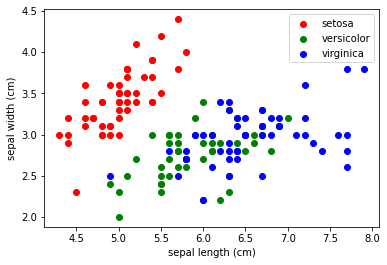

In [6]:
#change these two values to plot different features
feature_x = 0
feature_y = 1

#old reliable pyplot!
import matplotlib.pyplot as plt

#starting a new plot
fig, ax = plt.subplots()

#adding data in three bunches of 50, once per class
ax.scatter(x=iris.data.iloc[0:50,feature_x],    y=iris.data.iloc[0:50,feature_y],    c='red',   label=iris.target_names[0])
ax.scatter(x=iris.data.iloc[50:100,feature_x],  y=iris.data.iloc[50:100,feature_y],  c='green', label=iris.target_names[1])
ax.scatter(x=iris.data.iloc[100:150,feature_x], y=iris.data.iloc[100:150,feature_y], c='blue',  label=iris.target_names[2])

#the axis names are taken from feature names
ax.set_xlabel(iris.feature_names[feature_x])
ax.set_ylabel(iris.feature_names[feature_y])

#adding the legend and printing the plot
ax.legend()
plt.show()

In [7]:
#simplifly the problem: less classes, less variables
features = iris.data.iloc[:, 0:2]
target = iris.target
target[50:100] = 0 #this makes things difficult. For an easier problems set versicolor as virginica

In [8]:
#selecting the first 100 samples for training would be a bad choice...
print(Counter(iris.target[0:100]))

Counter({0: 100})


In [9]:
#TRAIN/TEST SETS
#I want to have the same proportion of classes in both train and test sets

#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)

for train_index, test_index in sss.split(features, target):
    features_train = features.iloc[train_index, :]
    features_test = features.iloc[test_index, :]
    target_train = target[train_index]
    target_test = target[test_index]
    
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(120, 2)
(30, 2)
(120,)
(30,)


In [10]:
#https://www.tensorflow.org/guide/keras/train_and_evaluate
from keras.models import Sequential
from keras.layers import Dense

# 2-class logistic regression in Keras
model = Sequential()
model.add(Dense(1, activation='sigmoid', input_dim=features_train.shape[1]))
model.compile(optimizer='rmsprop', loss='binary_crossentropy')
history = model.fit(features_train, target_train, epochs=10, validation_data=(features_test, target_test))

Epoch 1/10
4/4 [==============================] - 0s 35ms/step - loss: 2.1368 - val_loss: 2.1403
Epoch 2/10
4/4 [==============================] - 0s 7ms/step - loss: 2.0928 - val_loss: 2.1034
Epoch 3/10
4/4 [==============================] - 0s 6ms/step - loss: 2.0593 - val_loss: 2.0718
Epoch 4/10
4/4 [==============================] - 0s 6ms/step - loss: 2.0302 - val_loss: 2.0431
Epoch 5/10
4/4 [==============================] - 0s 7ms/step - loss: 2.0037 - val_loss: 2.0166
Epoch 6/10
4/4 [==============================] - 0s 7ms/step - loss: 1.9776 - val_loss: 1.9893
Epoch 7/10
4/4 [==============================] - 0s 7ms/step - loss: 1.9520 - val_loss: 1.9637
Epoch 8/10
4/4 [==============================] - 0s 7ms/step - loss: 1.9271 - val_loss: 1.9373
Epoch 9/10
4/4 [==============================] - 0s 7ms/step - loss: 1.9021 - val_loss: 1.9119
Epoch 10/10
4/4 [==============================] - 0s 7ms/step - loss: 1.8781 - val_loss: 1.8865


In [11]:
#take a look at losses evolution
def plot_loss_history(h, title):
    plt.plot(h.history['loss'], label = "Train loss")
    plt.plot(h.history['val_loss'], label = "Validation loss")
    plt.xlabel('Epochs')
    plt.title(title)
    plt.legend()
    plt.show()

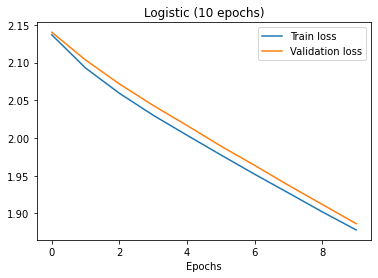

In [12]:
plot_loss_history(history, 'Logistic (10 epochs)')

In [13]:
#loss just goes down, we can keep training (whithout recompiling)
#putting verbose to 0 to avoid filling the screen
history2 = model.fit(features_train, target_train, epochs=490, 
                     validation_data=(features_test, target_test), verbose=0)

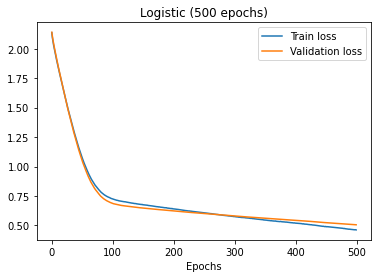

In [14]:
#putting together the whole history...
history.history['loss'] += history2.history['loss']
history.history['val_loss'] += history2.history['val_loss']

#...and plotting again!
plot_loss_history(history, 'Logistic (500 epochs)')

In [15]:
do_10000_epochs = False

In [16]:
#what happens if we keep going for a (very) long time?
if (do_10000_epochs):
    #train for 10000 epochs, just to show how the model evolves
    history3 = model.fit(features_train, target_train, epochs=9500, 
                         validation_data=(features_test, target_test), verbose=0)

    #putting together the whole history
    history.history['loss'] += history3.history['loss']
    history.history['val_loss'] += history3.history['val_loss']

    #and plotting again
    plot_loss_history(history, 'Logistic (10000 epochs)')

![regression_10000_epochs](../data/regression_loss10000.png "regression_10000_epochs")

In [17]:
if (do_10000_epochs):
    # logistic regression with L1 and L2 regularization
    from tensorflow.keras import regularizers
    model = Sequential()
    model.add(Dense(1, activation='sigmoid', input_dim=features_train.shape[1], 
                    kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-5)))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy')
    history_reg = model.fit(features_train, target_train, epochs=10000, 
                            validation_data=(features_test, target_test), verbose=0)
    #and plotting it
    plot_loss_history(history_reg, 'Logistic + L1L2 reg (10000 epochs)')

![regression_L1L2_10000_epochs](../data/regression_loss10000_regL1L2.png "regression_L1L2_10000_epochs")

In [18]:
if (do_10000_epochs):
    plt.plot(history.history['loss'], label = "Train loss")
    plt.plot(history_reg.history['loss'], label = "Train loss with regularization")
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

    plt.plot(history.history['val_loss'], label = "Validation loss")
    plt.plot(history_reg.history['val_loss'], label = "Validation loss with regularization")
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

![comparison_on_train_loss](../data/comparison_train_loss.png "Comparison on train-set Loss")
![comparison_on_val_loss](../data/comparison_val_loss.png "Comparison on validation-set Loss")

In [19]:
#implement logistic regression from scratch, without keras
#https://towardsdatascience.com/a-logistic-regression-from-scratch-3824468b1f88